# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## EDA portfolio data

In [3]:
portfolio.head(5)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# Split the channels column into 1/0s column
channels_list = ['email', 'mobile', 'social', 'web']

for channel in channels_list:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)

# Drop the original 'channels' column
portfolio.drop(columns=['channels'], inplace=True)
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


### Summary about Portfolio data:
- Buy one get one offer (BOGO): Has the reward and difficulty equal.
- Discount: Difficulty higher than reward.
- All the available offers are sent to email

## EDA Profile data

In [5]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
# Decide to change the profile the row which is Age = 118, Income = Nan and Gender = None to age = Nan
import numpy as np
profile.loc[((profile["age"] == 118) & (profile["income"].isna()) & (profile["gender"].isna())),"age"] = np.nan

In [7]:
profile[(profile["age"].isna()) & (profile["income"].isna()) & (profile["gender"].isna())].head(5)

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,NaN,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,NaN,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [8]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa51c516ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa51c4f6128>]], dtype=object)

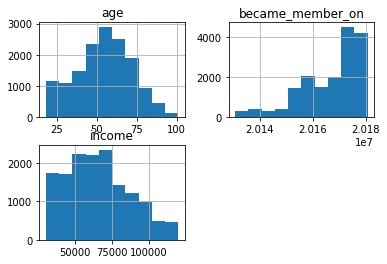

In [9]:
profile.hist()

In [80]:
profile.head(5)

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


### Summary about Profile data
- Age and income chart have the normal distribution with mean 54 and 65404 respectively
- became_member_on shows that the large of member is registered in 2018

## EDA Transcript data

In [10]:
# Clean data: 
# Check whether value in person column is availabled in profile
person_ids = profile["id"].unique()
is_values_present = transcript['person'].isin(person_ids)
filtered_df = transcript[~is_values_present]
filtered_df

,event,person,time,value


In [19]:
transcript_clean = transcript
transcript_clean['offer_id'] = transcript['value'].apply(lambda x: x.get("offer_id",None) if x.get("offer_id")!=None else x.get("offer id"))

# Display the result
transcript_clean

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [22]:
# Check whether value in offer_id column is availabled in portfolio
offer_ids = portfolio["id"].unique()
is_values_present = transcript_clean['offer_id'].isin(offer_ids)
filtered_df = transcript_clean[transcript_clean["event"]!="transaction"][~is_values_present]
filtered_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,event,person,time,value,offer_id


In [24]:
transcript_clean["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [25]:
len(transcript_clean["person"].unique())

17000

In [27]:
transcript_clean["offer_id"].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', None], dtype=object)

In [28]:
len(profile["id"].unique())

17000

In [29]:
len(portfolio["id"].unique())

10

In [30]:
set(transcript_clean["offer_id"]) - set(portfolio["id"])

{None}

### Summary about transcript data:
- all offer_id in trascript dataframe is existed in portfolio
- all person_id in transcript dataframe is existed in profile
- Number of transaction event is the highest, it makes sense. 

User has the trend to re-complete the offer if the offer is the same. Moreover, user who complete the offer incidentally (who doesn't view or receive the offer but complete the offer) is the potential customer of this kind of offer (Maybe they has the habit of purchasing that incidentally fit with the offer, or just totally the incident)

So to build the recommend offer system for each user, we split the system into two smaller system:
- re-completed recommendation system
- potential recommendation system

### 1. re-completed recommendation system

In [31]:
transcript_pivot = transcript_clean.pivot_table(index=['person', 'offer_id'], columns='event', values='time', fill_value=None).reset_index()
transcript_pivot

event,person,offer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,NaN,372.0,423.0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576.0,408.0,432.0
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252.0,168.0,186.0
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,NaN,0.0,6.0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,NaN,336.0,354.0


In [38]:
re_completed_df = transcript_pivot[(transcript_pivot["offer completed"].notna()) & (transcript_pivot["offer received"].notna()) & (transcript_pivot["offer viewed"].notna())]
re_completed_df 

event,person,offer_id,offer completed,offer received,offer viewed
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576.0,408.0,432.0
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252.0,168.0,186.0
10,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,576.0,504.0,516.0
11,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,510.0,408.0,426.0
14,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,282.0,168.0,12.0
15,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,222.0,168.0,168.0
17,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,600.0,504.0,582.0
18,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,378.0,336.0,348.0


In [47]:
def get_completed_offer_id(user_id):
    return list(re_completed_df[re_completed_df["person"] == user_id]["offer_id"])
get_completed_offer_id("0009655768c64bdeb2e877511632db8f")

['f19421c1d4aa40978ebb69ca19b0e20d', 'fafdcd668e3743c1bb461111dcafc2a4']

### 2. Potential completed system

In [45]:
potential_completed_df = transcript_pivot[(transcript_pivot["offer completed"].notna()) & ((~transcript_pivot["offer received"].notna()) | (~transcript_pivot["offer viewed"].notna()))]
potential_completed_df

event,person,offer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN
19,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,696.0,504.0,NaN
30,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,336.0,336.0,NaN
34,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9,582.0,504.0,NaN
36,0056df74b63b4298809f0b375a304cf4,0b1e1539f2cc45b7b9fa7c272da2e1d7,414.0,408.0,NaN
51,00715b6e55c3431cb56ff7307eb19675,4d5c57ea9a6940dd891ad53e9dbe8da0,342.0,336.0,NaN
59,00840a2ca5d2408e982d56544dc14ffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,522.0,408.0,NaN
80,0099bf30e4cb4265875266eb3eb25eab,0b1e1539f2cc45b7b9fa7c272da2e1d7,420.0,336.0,NaN
106,00b3400e4ff64ee68ce9ada1d0c222f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,420.0,336.0,NaN
109,00b3400e4ff64ee68ce9ada1d0c222f0,ae264e3637204a6fb9bb56bc8210ddfd,264.0,168.0,NaN


In [62]:
def get_potential_offer_id(user_id):
    return list(potential_completed_df[potential_completed_df["person"] == user_id]["offer_id"])
get_potential_offer_id("a03223e636434f42ac4c3df47e8bac43")

[]

Not all users have completed at least one offer, so we will rely on common characteristics among users to infer which offers have not been completed.

Characteristics might be: 
- age, income, gender

In [54]:
def find_similar_user(user_id, dataframe):
    input_user = dataframe[dataframe['id'] == user_id]
    
    if input_user.empty:
        return None  # User not found in the dataframe
    
    # Filter out rows with missing values in the relevant columns
    filtered_df = dataframe.dropna(subset=['gender', 'age', 'income'])
    
    # Calculate similarity based on gender, age, and income
    similarities = (filtered_df['gender'] == input_user['gender'].values[0]) & \
                   (abs(filtered_df['age'] - input_user['age'].values[0]) <= 5) & \
                   (abs(filtered_df['income'] - input_user['income'].values[0]) <= 10000)
    
    # Get the most similar user
    similar_user = filtered_df[similarities]
    
    if not similar_user.empty:
        return similar_user
    else:
        return None  # No similar user found
find_similar_user("7429a044884842d6862f516c38b1156f", profile)

,age,became_member_on,gender,id,income
28,46.0,20170911,F,7429a044884842d6862f516c38b1156f,59000.0
91,49.0,20170408,F,68eee228713c429ebe1300155ad1fb33,57000.0
120,51.0,20170813,F,1a353048b0884fc5a0afa27677ef1e80,56000.0
184,50.0,20171108,F,348bdc19d65f49b8b98f72c59e64cd89,69000.0
267,49.0,20170809,F,7798d98a070845328d838312b65ba846,68000.0
292,48.0,20161014,F,9c64321646bf40f6ad1bc98864eaa6b8,53000.0
311,42.0,20170529,F,68081ac19eae44ba99b47c8e1d4161a4,56000.0
454,49.0,20171016,F,c2c72ce6038644c797208046d1e3498a,57000.0
459,44.0,20170918,F,6c0c0bacbe0b455c9c0a4ed0f72eb2f9,60000.0
481,41.0,20170730,F,5db55c030129497396446c4d07e15380,67000.0


In [66]:
def get_offer_id_from_similar_user(user_id):
    similar_ids = find_similar_user(user_id, profile)["id"]
    offer_id_score = {}
    # init the offer_id_score
    for offer_id in portfolio["id"]:
        offer_id_score[offer_id]=0
        
    for similar_id in similar_ids:
        offer_ids = get_completed_offer_id(similar_id)
        for offer_id in offer_ids:
            offer_id_score[offer_id]+=1
    
    sorted_offer_id_score = dict(sorted(offer_id_score.items(), key=lambda item: item[1], reverse=True))
    return sorted_offer_id_score

get_offer_id_from_similar_user("7429a044884842d6862f516c38b1156f")

{'2298d6c36e964ae4a3e7e9706d1fb8c2': 124,
 'fafdcd668e3743c1bb461111dcafc2a4': 107,
 'f19421c1d4aa40978ebb69ca19b0e20d': 103,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 90,
 'ae264e3637204a6fb9bb56bc8210ddfd': 88,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 81,
 '2906b810c7d4411798c6938adc9daaa5': 81,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 59,
 '3f207df678b143eea3cee63160fa8bed': 0,
 '5a8bc65990b245e5a138643cd4eb9837': 0}

In [79]:
from collections import OrderedDict

# re-completed offer -> potential offer -> similar user offer
def get_recommend_offer_id(user_id, number_offer_recommend):
    result = []
    re_completed_offer = get_completed_offer_id(user_id)
    result+=re_completed_offer
    potential_offer = get_potential_offer_id(user_id)
    result+=potential_offer
    try:
        similar_user_offer = list(get_offer_id_from_similar_user(user_id).keys())
        result+=similar_user_offer
    except:
        pass
    unique_list = list(OrderedDict.fromkeys(result))
    return result[:number_offer_recommend]

get_recommend_offer_id("7429a044884842d6862f516c38b1156f",5)

['2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 'ae264e3637204a6fb9bb56bc8210ddfd']